In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import seaborn as sn
from sklearn.model_selection import train_test_split
cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# use GPU when available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Print GPU name
print('GPU: ', torch.cuda.get_device_name(device=device))

#number of usable CPU cores
core_count = 8#len(os.sched_getaffinity(0))
print('CPU cores: ', core_count)

# current working directory
wd = os.getcwd()

GPU:  NVIDIA GeForce RTX 3060
CPU cores:  8


In [3]:
# # Data augmentation and normalization for training
# # Just normalization for validation
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

# data_dir = wd +'/hymenoptera_data'

# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'val']}


# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
#                                              shuffle=True, num_workers=core_count)
#               for x in ['train', 'val']}


# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes
# class_num = len(class_names)


In [4]:
#labels
labels_names = ['Stop','Yield','Red Light','Green Light','Roundabout','Right Turn Only',
                'Do Not Enter','Crosswalk','Handicap Parking','No Parking']

# Loading Data
data_train = np.load(wd+'/clean_data.npy')
reshaped_data = data_train.reshape((300,300,3,data_train.shape[1]))
reshaped_data = np.moveaxis(reshaped_data, source=[0, 1, 2, 3], destination=[2, 3, 1, 0])
labels_train = np.load(wd+'/clean_labels.npy')
labels_train = np.array(labels_train,dtype=int)

# split data
x_train, x_test, t_train, t_test = train_test_split(reshaped_data, labels_train, test_size=0.7)

x_train_te = torch.Tensor(x_train)
x_test_te = torch.Tensor(x_test)
t_train_te = torch.Tensor(t_train)
t_test_te = torch.Tensor(t_test)

image_datasets = {'train': TensorDataset(x_train_te,t_train_te),
                 'val': TensorDataset(x_test_te,t_test_te)}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True, num_workers=core_count)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = labels_names
class_num = len(class_names)

In [5]:
# def imshow(inp, title=None):
#     """Imshow for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  # pause a bit so that plots are updated


# # Get a batch of training data
# inputs, classes = next(iter(dataloaders['train']))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_dict = {'train':[[],[]], 'val':[[],[]]}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                labels = labels.type(torch.LongTensor) 
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            train_dict[phase][0].append(epoch_loss)
            train_dict[phase][1].append(epoch_acc.cpu().item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_dict

In [7]:
def visualize_model(model, num_images=10):   
    
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(20,20))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            print(inputs.max())
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.to(int)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2+1, num_images//2+1, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]} \n True: {class_names[labels[j]]}')
                plt.imshow(np.moveaxis(np.array(inputs.cpu().data[j], dtype=int), source=[0], destination=[2]))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
def known_predict(model, dataloader=dataloaders['val']):   
    
    was_training = model.training
    model.eval()
    
    labels_lst = []
    preds_lst = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.to(int)
            labels_lst.append(np.array(labels.cpu()))
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            preds_lst.append(np.array(preds.cpu()))
            
        model.train(mode=was_training)
    preds_ar = np.stack(preds_lst)
    labels_ar = np.stack(labels_lst)
    return preds_ar, labels_ar

In [9]:
# stack all arrays from output into a single lsit of numbers

In [10]:
# a, b = known_predict(model_conv, dataloader=dataloaders['val'])

In [11]:
# create unknown apply function
# export model

### Finetuning the convnet

In [12]:
# model_ft = torchvision.models.efficientnet_v2_l(weights='EfficientNet_V2_L_Weights.IMAGENET1K_V1')
# num_ftrs = model_ft.classifier[1].in_features

# # Here the size of each output sample is set to 2.
# # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model_ft.fc = nn.Linear(num_ftrs, class_num)

# model_ft = model_ft.to(device)

# criterion = nn.CrossEntropyLoss()

# # Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=25)

# visualize_model(model_ft)

# plt.ioff()
# plt.show()

### ConvNet as fixed feature extractor

In [13]:
model_conv = torchvision.models.efficientnet_v2_l(weights='EfficientNet_V2_L_Weights.IMAGENET1K_V1')

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier[1].in_features
model_conv.classifier = nn.Linear(num_ftrs, class_num)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
# optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)
optimizer_conv = optim.Adam(model_conv.classifier.parameters(), lr=0.011)


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

tensor(255.)


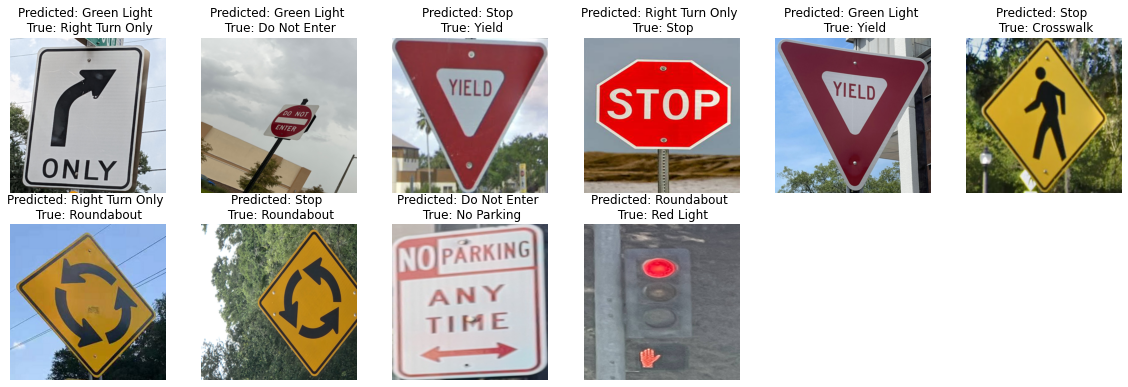

In [14]:
visualize_model(model_conv)

In [15]:
model_conv, train_dict_fixed = train_model(model_conv, 
                                           criterion, 
                                           optimizer_conv, 
                                           exp_lr_scheduler, 
                                           num_epochs=1)


Epoch 1/1
----------
train Loss: 1.1202 Acc: 0.6676


RuntimeError: DataLoader worker (pid(s) 21640, 21996, 4444, 16928, 13500, 10816, 7004, 15004) exited unexpectedly

In [ ]:
visualize_model(model_conv)

In [ ]:
df = pd.DataFrame()
df['train_loss'] = train_dict_fixed['train'][0]
df['val_loss'] = train_dict_fixed['val'][0]
df['train_acc'] = train_dict_fixed['train'][1]
df['val_acc'] = train_dict_fixed['val'][1]
df.to_csv('accuracies.csv')
plt.figure(figsize=(16,8))
sn.lineplot(data=df[['train_acc', 'val_acc']])
plt.show()

plt.figure(figsize=(16,8))
sn.lineplot(data=df[['train_loss', 'val_loss']])
plt.show()

In [ ]:
plt.savefig('250_epochs.png')